In [87]:
import numpy as np
import cv2
import os
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

# Utils

In [88]:
def add_noise(imgs):
    """
    Main function add noise to images.

    Here we load the dataset, add gaussian, poisson, speckle
    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    """
    row, col = 28, 28
    noisy_output = np.zeros((len(imgs), row, col))
    
    # adding noise
    for idx, img in enumerate(imgs):
        img = img.astype(np.float32)
        noise_type = random.choice(["gaussian", "speckle"])

        if noise_type == "gaussian":
            mean, var = -10, 100
            sigma = var**.5
            noise = np.random.normal(20, 10, img.shape)
            img += noise

        elif noise_type == "speckle":
            noise = np.random.randn(row,col)
            noise = noise.reshape(row,col)
            img += img * noise


        noisy_output[idx] = img
        
    return noisy_output

# Load and Split Data

In [89]:
# Loading the dataset from Keras
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=10000, random_state=42)

In [90]:
print(f"Number of Training Set datapoints: {len(xtrain)}")
print(f"Number of Validation Set datapoints: {len(xval)}")
print(f"Number of Test Set datapoints: {len(xtest)}")

Number of Training Set datapoints: 50000
Number of Validation Set datapoints: 10000
Number of Test Set datapoints: 10000


## Add Noise

In [91]:
"""
Split Data and Add Noise

We split the 50k training data into 2 sets where we add 1 type of noise to each set. 
"""
import random

# We define two types of noises
noise_types = ["gaussian","speckle"]

# adding noise to xtrain and xtest
noisy_xtrain = add_noise(xtrain)
noisy_xval = add_noise(xval)
noisy_xtest = add_noise(xtest)

## Visualize Noise

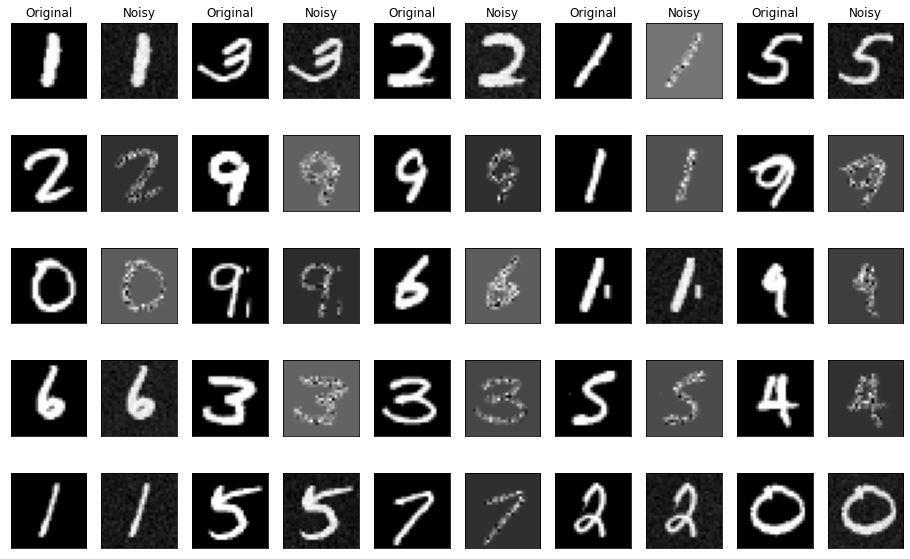

In [92]:
"""
Visualization of Original Image vs. Noisy Image.
"""
import itertools
f, axes = plt.subplots(5, 10, figsize=(16, 10))

for xid, yid in itertools.product(range(5), range(0, 10, 2)):
    image_id = random.randint(0, 50000)
    
    # display original image
    axes[xid, yid].imshow(xtrain[image_id],cmap="gray")
    axes[xid, yid].set(xticks = [], yticks = [])

    # display original image
    axes[xid, yid+1].imshow(noisy_xtrain[image_id],cmap="gray")
    axes[xid, yid+1].set(xticks = [], yticks = [])
    
    if xid == 0:
        axes[xid, yid].set(title = "Original")
        axes[xid, yid+1].set(title = "Noisy")

## Data Loader

In [93]:
"""
Dataset
"""
class noisedDataset(Dataset):
  
    def __init__(self, noisy_dataset, clean_dataset, labels, transform):
        self.noise = noisy_dataset
        self.clean = clean_dataset
        self.labels = labels
        self.transform = transform
  
    def __len__(self):
        return len(self.noise)
  
    def __getitem__(self,idx):
        noisy_x = self.noise[idx]
        clean_x = self.clean[idx]
        y = self.labels[idx]
    
        if self.transform != None:
            noisy_x = self.transform(noisy_x)
            clean_x = self.transform(clean_x)

        return (noisy_x, clean_x, y)  

In [94]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(noisy_xtrain, xtrain, ytrain, tsfms)
valset = noisedDataset(noisy_xval, xval, yval, tsfms)
testset = noisedDataset(noisy_xtest, xtest, ytest, tsfms)

In [95]:
batch_size = 32

train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=True)

# Denoising Autoencoder (DAE) Model

In [96]:
"""
Autoencoder model
"""
# TODO: Main model definition + any utilities or custom layers

# Required Import 
import torch.nn.functional as F


# Denoising Auto Encoder consists 2 FC Layers in Encoding Part and 2  FC layer in Decoding Part.
# latent-space size is 64 nodes.
# Hourglass Shape Architecture

class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        # Transforms 1 x 784 to 1 x 300
        self.fc1 = torch.nn.Linear(28*28, 300, True)

        # Transforms 1 x 300 to 1 x 64
        self.fc2 = torch.nn.Linear(300, 64, True)

        # Transforms 1 x 64 to 1 x 300
        self.fc3 = torch.nn.Linear(64, 300, True)

        # Transforms 1 x 300 to 1 x 784
        self.fc4 = torch.nn.Linear(300, 28*28, True)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the Image for FC Layer

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = torch.sigmoid(self.fc4(x)) # Sigmoid is used because we need values between 0 and 1

        x = x.view(x.size(0), 1, 28, 28) # Unflatten the Image
        return x

# Training

In [97]:
"""
Main Train Script
"""
def train(train_dataloader, val_dataloader, device, config):
    model = DAE().to(device)
    # epochs_loss is losses for epochs --> len(epochs_loss) = number of epochs
    epochs_loss = []

    # Initalize Hyperparameters
    num_epochs = config["num_epochs"]
    learning_rate = config["learning_rate"]

    # We use Adam as the optimizer for Gradient Descent
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # TRAINING + VALIDATION 
    for epoch in range(num_epochs):

      # TRAIN
      model.train()
      
      # Note we don't use label since it's unsupervised learning
      for batch_idx, (data, target, label) in enumerate(train_dataloader):
        # data is the noisy image 
        data = data.to(device)

        # target is the clean original image
        target = target.to(device)

        # Set gradients to zero
        optimizer.zero_grad()

        # Get the cleaned output by passing the noist image through the DAE
        output = model(data.float())

        # Calculate Loss
        loss = F.mse_loss(output, target)

        # Calculate Gradients via Backpropagation
        loss.backward()

        # Do gradient Descent
        optimizer.step()

        # Train Loss at regular Intervals
        if batch_idx % 200 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))

      # VALIDATION
      model.eval()
      validation_loss = 0
      correct = 0

      with torch.no_grad():

        # Note we don't use label since it's unsupervised learning
        for data, target, label in val_dataloader:
          # data is the noisy image 
          data = data.to(device)

          # target is the clean original image
          target = target.to(device)

          # Get the cleaned output by passing the noist image through the DAE
          output = model(data.float())

          # Calculate Loss
          validation_loss += F.mse_loss(output, target).item()

      # Calculate Average Validation Loss for the epoch
      validation_loss /= len(val_dataloader.dataset)
      epochs_loss.append(validation_loss)
      print('\nEpoch: {} Validation set: Avg. loss: {:.6f}\n'.format(epoch, validation_loss))

        
    return model, epochs_loss

"""
Saving Model Script
"""
def save_model_local_for_submission(model):  # if you are running on your local machine
    torch.save(model.to(torch.device("cpu")), 'checkpoint/dae_model.pt')

# Run

In [98]:
def run():
    # set parameters
    config = {
        'num_epochs': 20,
        'learning_rate': 0.001,
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, epochs_loss = train(train_dataloader, val_dataloader, device, config)
    
    # save model in checkpoint dir
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    save_model_local_for_submission(model)
    
    return model, epochs_loss

Train Epoch: 0 [0/50000 (0%)]	Loss: 0.382608
Train Epoch: 0 [6400/50000 (13%)]	Loss: 0.045490
Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.032191
Train Epoch: 0 [19200/50000 (38%)]	Loss: 0.034128
Train Epoch: 0 [25600/50000 (51%)]	Loss: 0.030418
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.029159
Train Epoch: 0 [38400/50000 (77%)]	Loss: 0.026705
Train Epoch: 0 [44800/50000 (90%)]	Loss: 0.023140

Epoch: 0 Validation set: Avg. loss: 0.027102

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.022328
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.030846
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.025752
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.028296
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.026234
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.028329
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.023209
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.021957

Epoch: 1 Validation set: Avg. loss: 0.025160

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.025511
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.026254
Train Epoch: 2 [12800/50

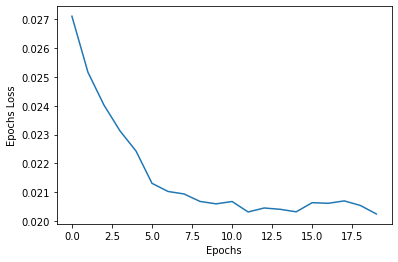

In [99]:
def main():
    
    model, epochs_loss = run()
    
    # plot loss in each epoch
    plt.plot(range(len(epochs_loss)), epochs_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Epochs Loss')
    
    return model
    
model = main()

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Visualize Denoising Test Set

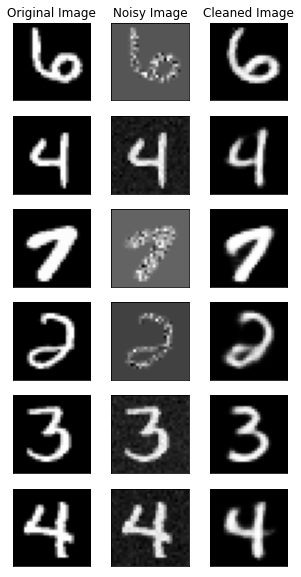

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

f, axes= plt.subplots(6, 3, figsize = (5, 10))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Noisy Image")
axes[0,2].set_title("Cleaned Image")

for idx, (noisy, clean, label) in enumerate(test_dataloader):
    if idx > 5:
        break
    
    # denoising with DAE
    noisy = noisy.view(noisy.size(0),-1).type(torch.FloatTensor)
    
    # this line must be commented to avoid illegal memory access error
    # noisy = noisy.to(device)
    output = model(noisy)
    
    # fix size
    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()
    
    noisy = noisy.view(1, 28, 28)
    noisy = noisy.permute(1, 2, 0).squeeze(2)
    
    # this line must be commented to avoid illegal memory access error
    # noisy = noisy.detach().cpu().numpy()

    clean = clean.view(1, 28, 28)
    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()
    
    # plot
    axes[idx, 0].imshow(clean, cmap="gray")
    axes[idx, 1].imshow(noisy, cmap="gray")
    axes[idx, 2].imshow(output, cmap="gray")
    
    axes[idx, 0].set(xticks=[], yticks=[])
    axes[idx, 1].set(xticks=[], yticks=[])
    axes[idx, 2].set(xticks=[], yticks=[])

# Evaluation with Peak Signal to Noise Ratio (PSNR) Metric

In [102]:
def evaluate(model, test_dataloader):
    psnr_noisy = []
    psnr_clean = []
    for noisy, original, label in tqdm(test_dataloader):
        # denoising with DAE
        noisy = noisy.view(noisy.size(0),-1).type(torch.FloatTensor)
        
        # this line must be commented to avoid illegal memory access error
        # noisy = noisy.to(device)
        clean = model(noisy)

        # fix size
        clean = clean.view(1, 28, 28)
        clean = clean.permute(1, 2, 0).squeeze(2)
        clean = clean.detach().cpu().numpy()

        noisy = noisy.view(1, 28, 28)
        noisy = noisy.permute(1, 2, 0).squeeze(2)
        noisy = noisy.detach().cpu().numpy()

        original = original.view(1, 28, 28)
        original = original.permute(1, 2, 0).squeeze(2)
        original = original.detach().cpu().numpy()
        
        psnr_noisy.append(cv2.PSNR(noisy, original))
        psnr_clean.append(cv2.PSNR(clean, original))
        
    return np.mean(psnr_noisy), np.mean(psnr_clean)

In [103]:
psnr_noisy, psnr_clean = evaluate(model, test_dataloader)

100%|██████████| 10000/10000 [00:05<00:00, 1915.06it/s]


In [104]:
print(f'PSNR improved from {psnr_noisy} for Noisy Images to {psnr_clean} for denoised images by DAE.')

PSNR improved from 7.749528162387904 for Noisy Images to 65.82415945761643 for denoised images by DAE.
